# upol

In [13]:
import sys,os
os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from fitlab.resman import RESMAN
import fitlab.nest

## setup

In [14]:
path = 'outputs/upol'

In [15]:
conf=load_config('%s/upol.py'%path)
resman=RESMAN(conf)
parman=resman.conf['parman']
nest=load('%s/nest'%path)
nest.keys()

IOError: [Errno 2] No such file or directory: 'outputs/upol/upol.py'

## analyze nested sampling statistics

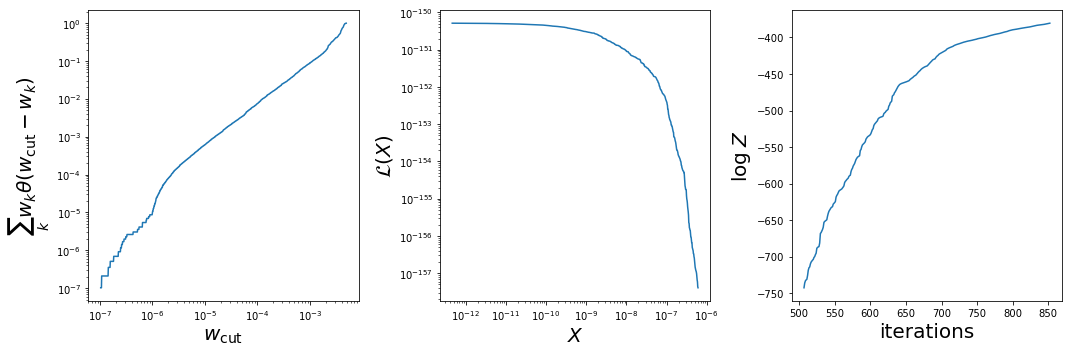

In [6]:
wmin_cut=1e-7

nrows,ncols=1,3
py.figure(figsize=(ncols*5,nrows*5))

ax=py.subplot(nrows,ncols,1)
weights=np.copy(nest['weights'])
weights=[w for w in weights if w>wmin_cut]
wmin=np.amin(weights)
wmax=np.amax(weights)
w=10**np.linspace(np.log10(wmin),np.log10(wmax),1000)
wsum=lambda wcut: np.sum([w for w in weights if w<wcut])
ax.plot(w,[wsum(wcut) for wcut in w])
ax.semilogx();
ax.semilogy();
ax.set_ylabel(r'$\sum_k w_k \theta(w_{\rm cut}-w_k)$',size=20)
ax.set_xlabel(r'$w_{\rm cut}$',size=20)

ax=py.subplot(nrows,ncols,2)
X=[nest['x'][i] for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
L=[nest['l'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
ax.plot(X,L)
ax.semilogx()
ax.semilogy()
ax.set_ylabel(r'${\cal L}(X)$',size=20)
ax.set_xlabel(r'$X$',size=20)

ax=py.subplot(nrows,ncols,3)
it=[i for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
LOGZ=[nest['logz'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
ax.plot(it,LOGZ)
ax.set_ylabel(r'$\log \;Z$',size=20)
ax.set_xlabel(r'iterations',size=20)

py.tight_layout()

## remove samples using sum_w cut criterion.  

In [7]:
weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
weights/=np.sum(weights)
fnest={}
fnest['weights']=weights
fnest['samples']=samples
print 'nes=%d  fnest=%d'%(len(nest['samples']),len(fnest['samples']))

nes=1718  fnest=853


## data vs theory

In [17]:
# time consuming: run if is necessary

# def get_RAW():
#     RAW={}
#     for k in conf['datasets']: RAW[k]={}
#     for kk in conf['datasets'][k]['xlsx']: RAW[k][kk]=[]
#     return RAW
        
# samples=fnest['samples']
# weights=fnest['weights']

# THY=get_RAW()
# RES=get_RAW()
# bar=BAR('gen chi2 values',len(samples))
# for i in range(len(samples)):
#     par=samples[i]
#     resman.get_residuals(par)
#     for k in RES:
#         for kk in RES[k]: 
#             if k=='sidis': 
#                 THY[k][kk].append(resman.sidisres.tabs[kk]['thy'])
#                 RES[k][kk].append(resman.sidisres.tabs[kk]['residuals'])
#     bar.next()
# bar.finish()
# RAW={'THY':THY,'RES':RES}
# save(RAW,'%s/raw'%path)

In [8]:
RAW=load('%s/raw'%path)

In [9]:
RES=RAW['RES']
THY=RAW['THY']

for k in RES:
    for kk in RES[k]: 
        if k=='sidis': 
            thy =np.einsum('k,ki',weights,THY[k][kk])
            dthy=np.einsum('k,ki',weights,(np.array(THY[k][kk])-thy)**2)**0.5
            residuals=np.einsum('k,ki',weights,RES[k][kk])
            resman.sidisres.tabs[kk]['thy']=thy
            resman.sidisres.tabs[kk]['dthy']=dthy
            resman.sidisres.tabs[kk]['residuals']=residuals
            resman.sidisres.tabs[kk]['chi2']=residuals**2
            resman.sidisres.tabs[kk]=pd.DataFrame(resman.sidisres.tabs[kk])

## Plot M

In [ ]:
def plot_M(kk):
    tab=resman.sidisres.tabs[kk]
    tab['rz']=np.round(tab['z'],2)
    tab['rQ2']=np.round(tab['Q2'],1)
    Q2=sorted(set(tab.rQ2))
    ncols=4
    nrows=len(Q2)/ncols
    if len(Q2)%ncols!=0: nrows+=1
    py.figure(figsize=(ncols*5,nrows*5))
    for i in range(len(Q2)):
        d1=tab.query('rQ2==%f'%Q2[i])
        ax=py.subplot(nrows,ncols,i+1)
        #rz=sorted(set(d1.rz))
        rz=[[0,0.19],[0.2,0.25],[0.26,0.29],[0.3,0.35],[0.4,0.5],[0.5,1]]
        cnt=0
        for _rz in rz:
            #d2=d1.query('rz==%f'%_rz)
            d2=d1.query('rz>%f and rz<%f'%(_rz[0],_rz[1]))
            I=np.argsort(d2.pT.values)
            scale=4**cnt
            cnt+=1
            p=ax.errorbar(d2.pT,d2.value*scale,d2.alpha*scale,fmt='.',label='z=[%0.2f,%0.2f]'%(_rz[0],_rz[1]))
            if len(d2.index)>1:
                #ax.plot(d2.pT.values[I],d2.thy.values[I]*scale,color=p[0].get_color())
                ax.fill_between(d2.pT.values[I],\
                                (d2.thy.values[I]-d2.dthy.values[I])*scale,\
                                (d2.thy.values[I]+d2.dthy.values[I])*scale,\
                                color=p[0].get_color())

            else:
                ax.plot(d2.pT.values[I],d2.thy.values[I]*scale,color=p[0].get_color(),marker='x')
            if i==0: ax.set_ylabel('M(HERMES)x4^i',size=20)
            ax.set_xlabel('$p_T$',size=20)
            ax.set_title('Q2=%0.2f  x=%0.2f'%(Q2[i],d2.x.values[0]),size=20)
            #ax.set_ylim(0.01,20)
            ax.semilogy(nonposy='clip')
            msg='%s(%d)'%(d2.hadron.values[0],kk)
            ax.text(0.1,0.1,msg,size=20,transform=ax.transAxes)

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

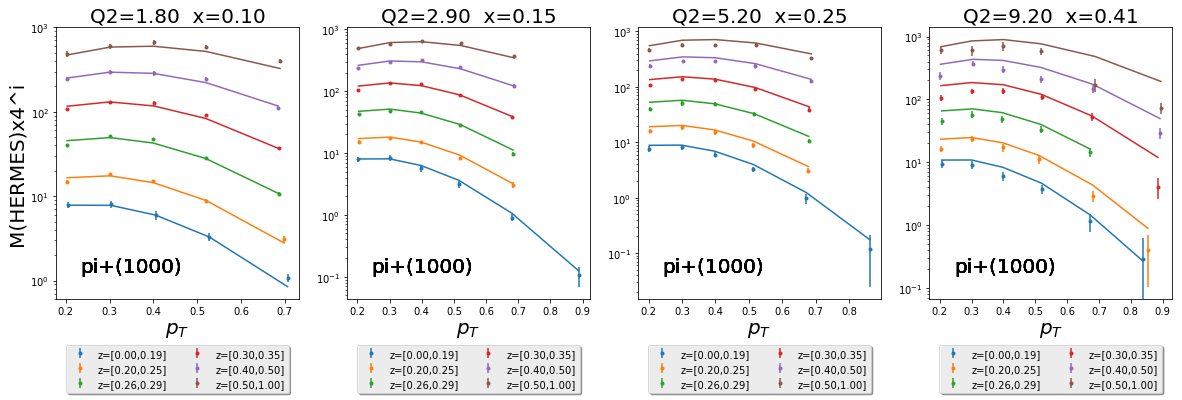

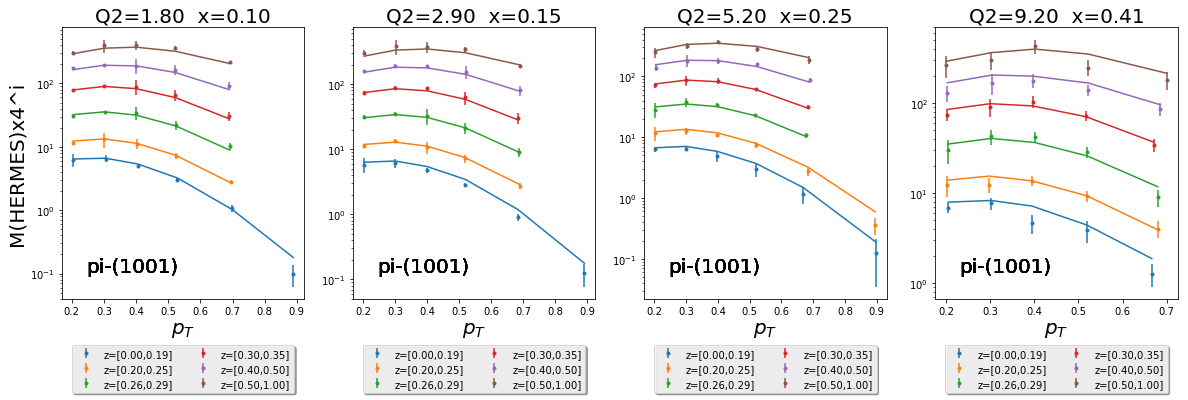

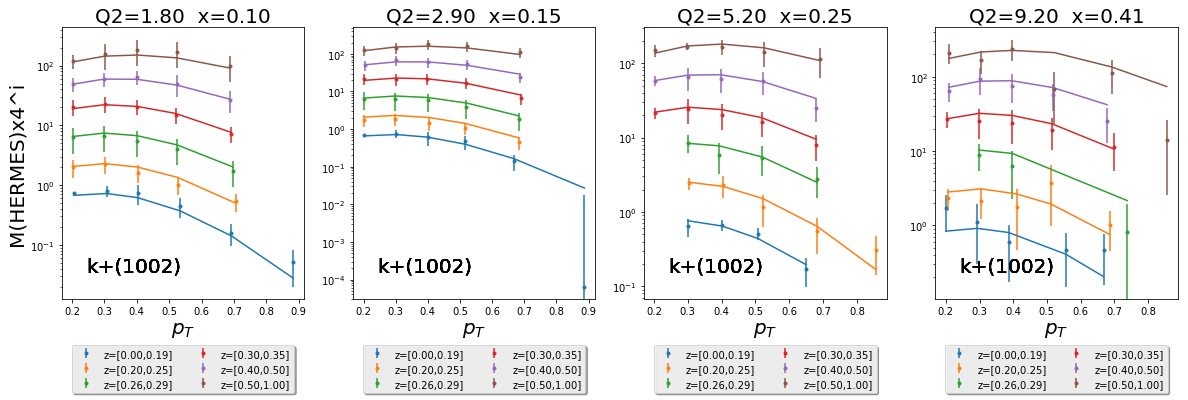

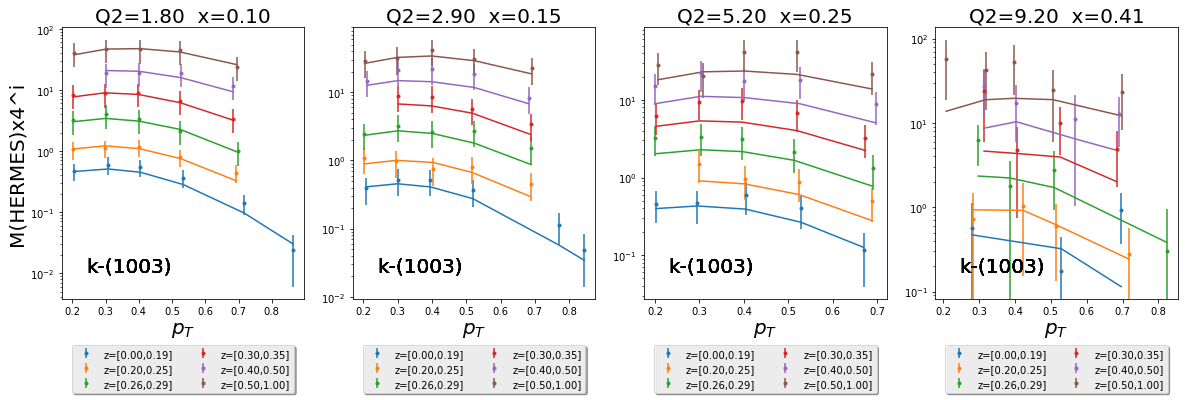

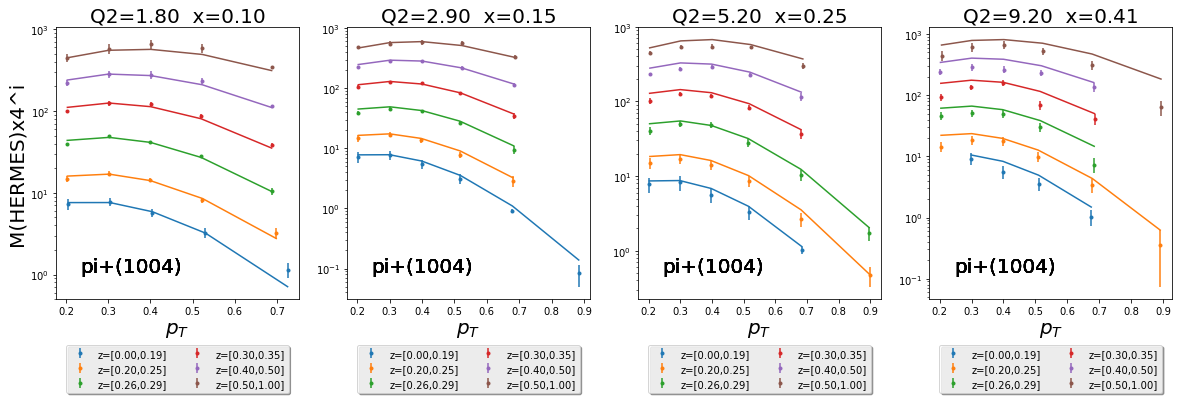

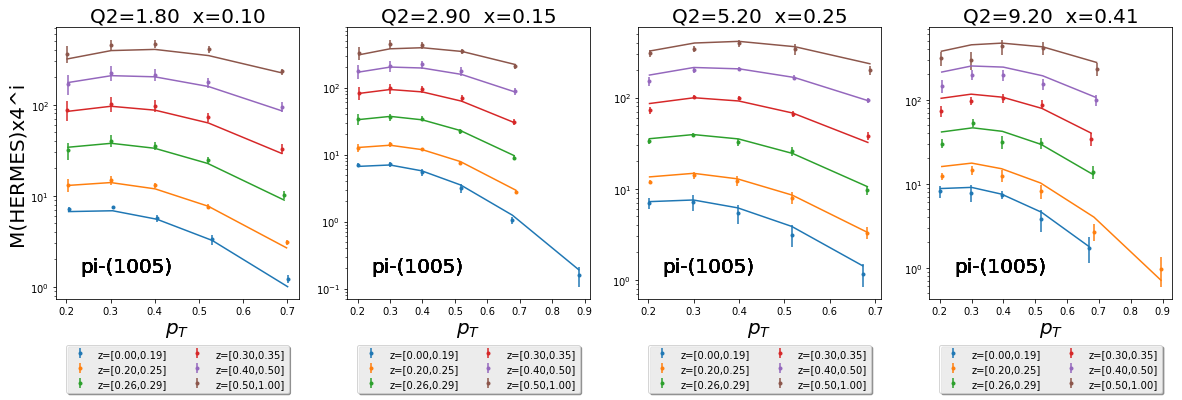

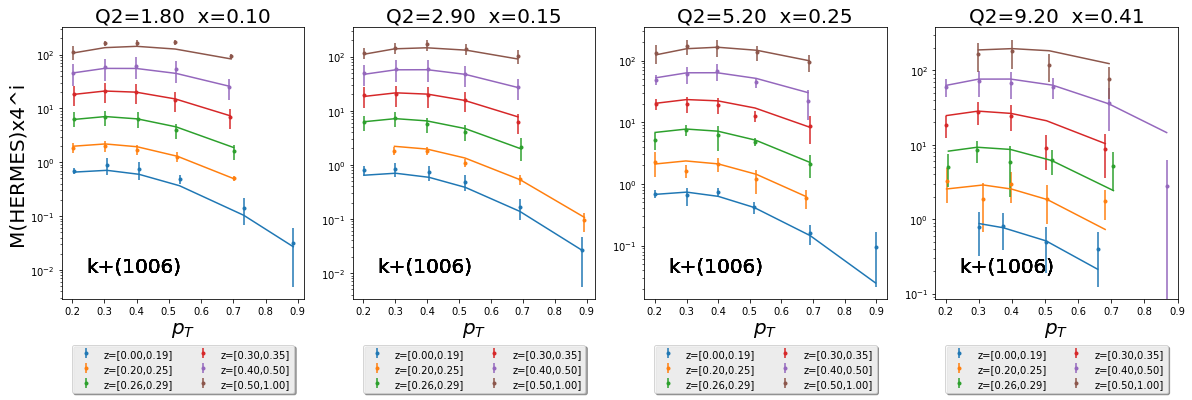

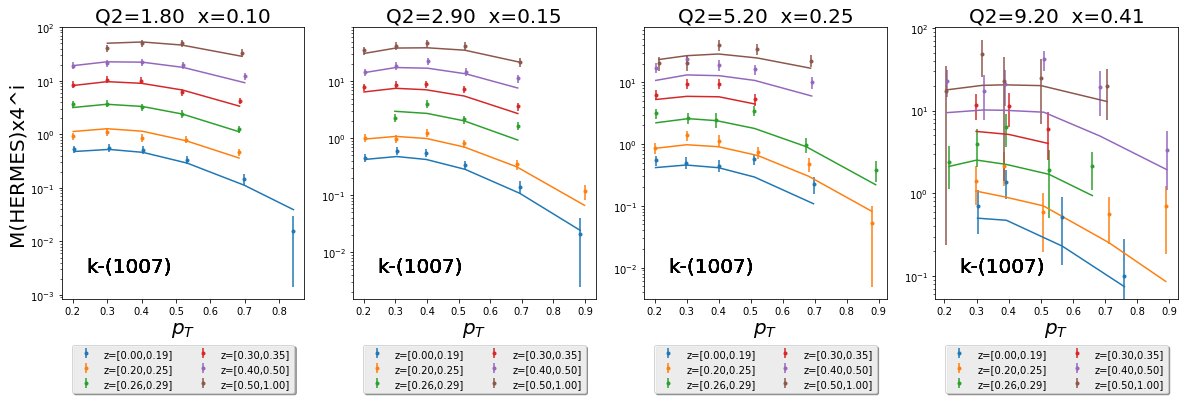

In [12]:
K=resman.sidisres.tabs.keys()
K=[k for k in K if k<2000 ]
for k in K:
    plot_M(k)

## parameters

In [143]:
def plot_params(k,kk):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par=np.transpose(samples)[get_idx(kk[i])]
        mean=np.einsum('k,k',weights,par) 
        std=np.einsum('k,k',weights,(np.array(par)-mean)**2)**0.5 
        ax.hist(par,histtype='stepfilled',weights=weights,bins=10,facecolor='Yellow',edgecolor='k')
        pmin=conf['params'][k][kk[i]]['min']
        pmax=conf['params'][k][kk[i]]['max']
        ax.set_xlim(pmin,pmax)
        #par=samples[get_idx(kk[i])]
        #ax.hist(par,histtype='stepfilled',weights=nes['weights'],range=(pmin,pmax),bins=10,facecolor='Yellow',edgecolor='k')        ax.hist(par1,histtype='stepfilled',weights=core1.nes['weights'],range=(pmin,pmax),bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_title('%s-%s'%(k,kk[i]))
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    py.tight_layout()


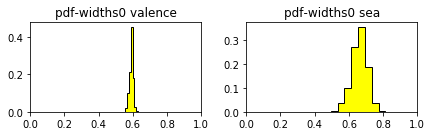

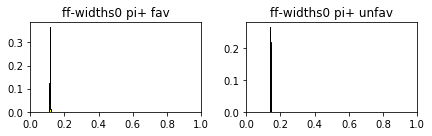

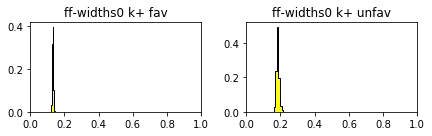

In [144]:
plot_params('pdf',['widths0 valence','widths0 sea'])
plot_params('ff',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('ff',['widths0 k+ fav','widths0 k+ unfav'])